In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

%matplotlib inline
debug = False
tolerance = 1e-5

In [4]:

import matplotlib.pyplot as plt

%matplotlib inline
debug = False
tolerance = 1e-5

In [5]:
def robertson_system(t, y):
    y1, y2, y3 = y
    dy1dt = -0.04 * y1 + 1e4 * y2 * y3
    dy2dt = 0.04 * y1 - 1e4 * y2 * y3 - 6e7 * y2**2
    dy3dt = 3e7 * y2**2
    return np.array([dy1dt, dy2dt, dy3dt])

In [6]:
y0 = np.array([1.0, 0.0, 0.0])
t_start = 0
t_end = 40

In [7]:
def explicit_rk4(f, t_span, y0, h):
    t = np.arange(t_span[0], t_span[1] + h, h)
    y = np.zeros((len(t), len(y0)))
    y[0] = y0

    for i in range(len(t)-1):
        k1 = f(t[i], y[i])
        k2 = f(t[i] + h/2, y[i] + h/2 * k1)
        k3 = f(t[i] + h/2, y[i] + h/2 * k2)
        k4 = f(t[i] + h, y[i] + h * k3)
        y[i+1] = y[i] + h/6 * (k1 + 2*k2 + 2*k3 + k4)

    return t, y

h_explicit = 1e-4
t_rk4, y_rk4 = explicit_rk4(robertson_system, (t_start, t_end), y0, h_explicit)

In [8]:
def implicit_rk_lobatto_iiia(f, t_span, y0, h):
    t = np.arange(t_span[0], t_span[1] + h, h)
    y = np.zeros((len(t), len(y0)))
    y[0] = y0
    
    for i in range(len(t)-1):
        def equations(k_flat):
            k1 = k_flat[:3]
            k2 = k_flat[3:]
            
            y_intermediate = y[i] + h*(0.5*k1 - 0.5*k2)
            y_next = y[i] + h*(0.5*k1 + 0.5*k2)
            
            residual1 = k1 - f(t[i], y_intermediate)
            residual2 = k2 - f(t[i] + h, y_next)
            
            return np.concatenate([residual1, residual2])
        
        k_initial_guess = np.zeros(6)
        
        k_sol_flat = fsolve(equations, k_initial_guess)
        
        k1 = k_sol_flat[:3]
        k2 = k_sol_flat[3:]
        
        y[i+1] = y[i] + h*(0.5*k1 + 0.5*k2)
    
    return t, y

h_implicit_rk = 1e-3
t_irk, y_irk = implicit_rk_lobatto_iiia(robertson_system, (t_start, t_end), y0, h_implicit_rk)

In [ ]:
def implicit_adams(f, t_span, y0, h, order=3):
    t = np.arange(t_span[0], t_span[1] + h, h)
    y = np.zeros((len(t), len(y0)))
    y[0] = y0

    for i in range(1, order):
        k1 = f(t[i-1], y[i-1])
        k2 = f(t[i-1] + h/2, y[i-1] + h/2 * k1)
        k3 = f(t[i-1] + h/2, y[i-1] + h/2 * k2)
        k4 = f(t[i-1] + h, y[i-1] + h * k3)
        y[i] = y[i-1] + h/6 * (k1 + 2*k2 + 2*k3 + k4)

    beta = [3/8, 19/24, -5/24, 1/24]

    for i in range(order, len(t)):
        def equation(y_next):
            return y_next - y[i-1] - h * (
                beta[0]*f(t[i], y_next) +
                beta[1]*f(t[i-1], y[i-1]) +
                beta[2]*f(t[i-2], y[i-2]) +
                beta[3]*f(t[i-3], y[i-3])
            )

        y[i] = fsolve(equation, y[i-1])

    return t, y

h_adams = 1e-3
t_adams, y_adams = implicit_adams(robertson_system, (t_start, t_end), y0, h_adams)


In [ ]:
def rosenbrock_method(f, t_span, y0, h):
    t = np.arange(t_span[0], t_span[1] + h, h)
    y = np.zeros((len(t), len(y0)))
    y[0] = y0

    gamma = 0.5 + np.sqrt(3)/6  

    for i in range(len(t)-1):
        def jacobian(y):
            eps = 1e-8
            n = len(y)
            J = np.zeros((n, n))
            f0 = f(t[i], y)
            for j in range(n):
                y_eps = y.copy()
                y_eps[j] += eps
                J[:, j] = (f(t[i], y_eps) - f0) / eps
            return J

        J = jacobian(y[i])
        I = np.eye(len(y0))

        A = I - h*gamma*J
        b = f(t[i], y[i])
        k1 = np.linalg.solve(A, b)

        y[i+1] = y[i] + h * k1

    return t, y

h_rosenbrock = 1e-1
t_ros, y_ros = rosenbrock_method(robertson_system, (t_start, t_end), y0, h_rosenbrock)


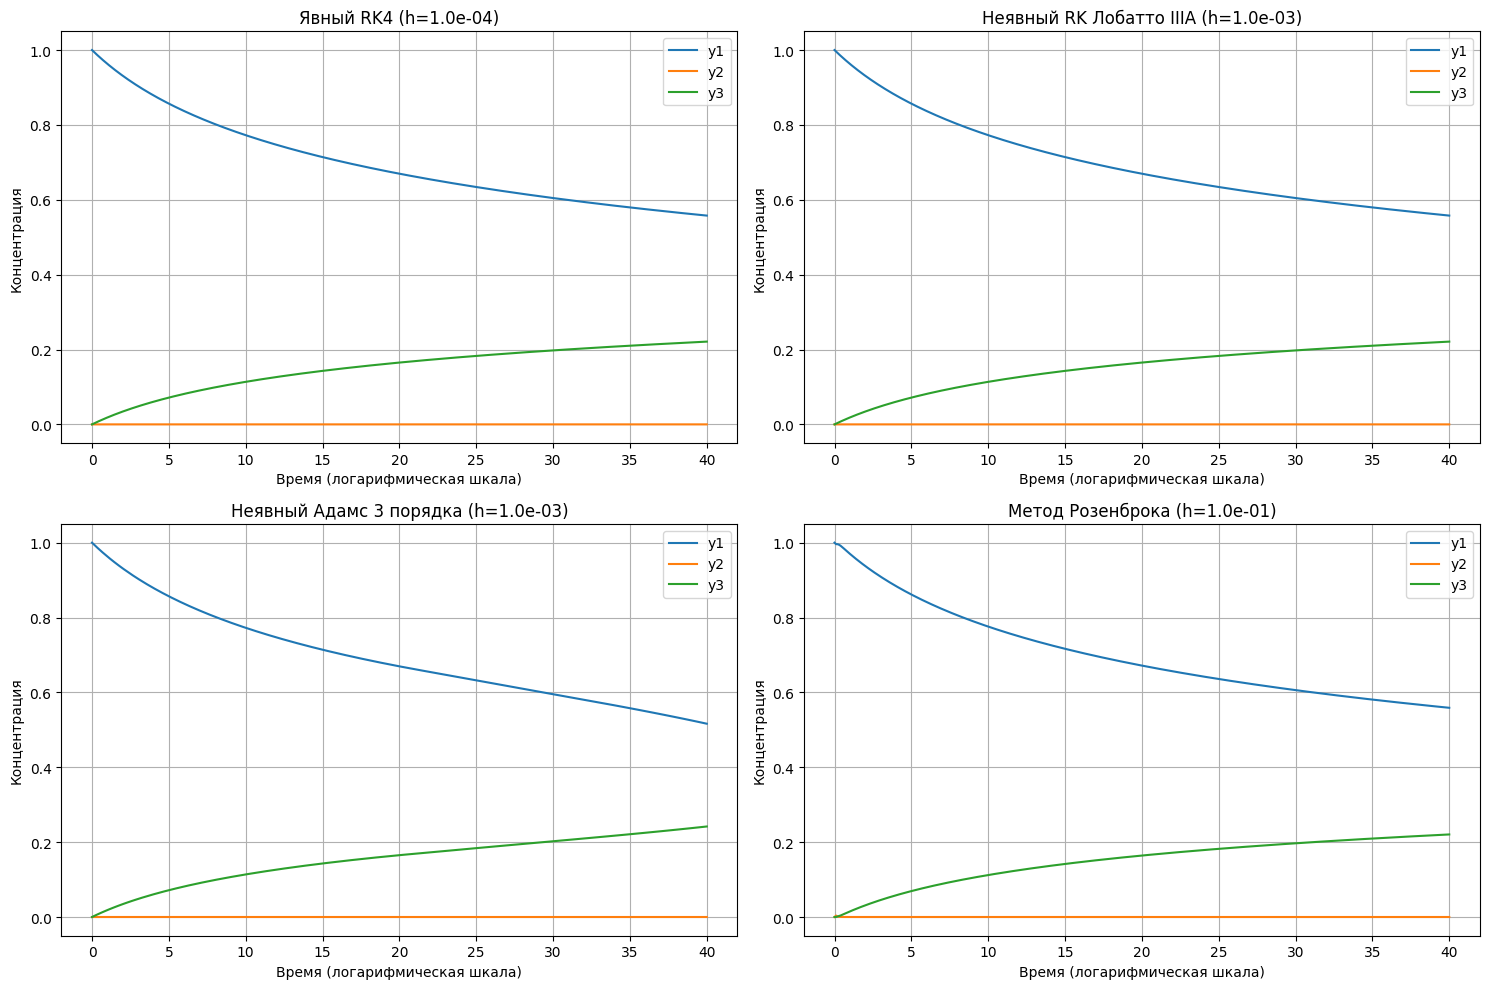

In [11]:
plt.figure(figsize=(15, 10))

# Логарифмическая шкала времени для лучшего отображения
plt.subplot(2, 2, 1)
plt.plot(t_rk4, y_rk4[:, 0], label='y1')
plt.plot(t_rk4, y_rk4[:, 1], label='y2')
plt.plot(t_rk4, y_rk4[:, 2], label='y3')
plt.title(f'Явный RK4 (h={h_explicit:.1e})')
plt.xlabel('Время (логарифмическая шкала)')
plt.ylabel('Концентрация')
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(t_irk, y_irk[:, 0], label='y1')
plt.plot(t_irk, y_irk[:, 1], label='y2')
plt.plot(t_irk, y_irk[:, 2], label='y3')
plt.title(f'Неявный RK Лобатто IIIA (h={h_implicit_rk:.1e})')
plt.xlabel('Время (логарифмическая шкала)')
plt.ylabel('Концентрация')
plt.legend()
plt.grid()

plt.subplot(2, 2, 3)
# plt.semilogx(t_adams, y_adams[:, 0], label='y1')
# plt.semilogx(t_adams, y_adams[:, 1], label='y2')
# plt.semilogx(t_adams, y_adams[:, 2], label='y3')
plt.plot(t_adams, y_adams[:, 0], label='y1')
plt.plot(t_adams, y_adams[:, 1], label='y2')
plt.plot(t_adams, y_adams[:, 2], label='y3')
plt.title(f'Неявный Адамс 3 порядка (h={h_adams:.1e})')
plt.xlabel('Время (логарифмическая шкала)')
plt.ylabel('Концентрация')
plt.legend()
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(t_ros, y_ros[:, 0], label='y1')
plt.plot(t_ros, y_ros[:, 1], label='y2')
plt.plot(t_ros, y_ros[:, 2], label='y3')
plt.title(f'Метод Розенброка (h={h_rosenbrock:.1e})')
plt.xlabel('Время (логарифмическая шкала)')
plt.ylabel('Концентрация')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

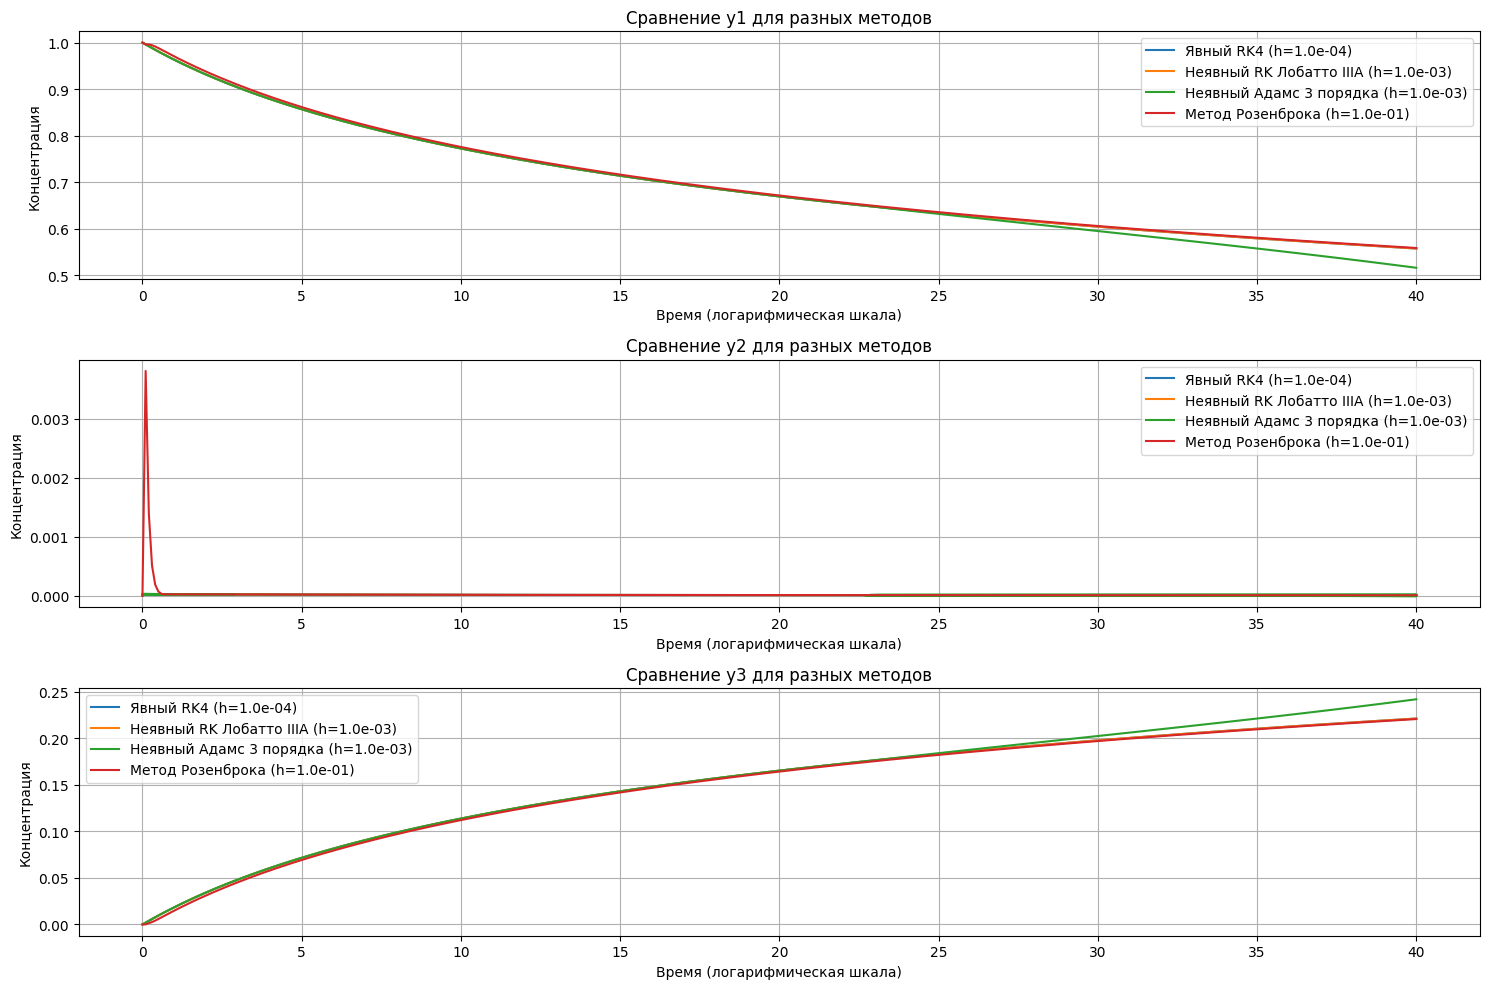

In [12]:
plt.figure(figsize=(15, 10))

# График для y1
plt.subplot(3, 1, 1)
plt.plot(t_rk4, y_rk4[:, 0], label=f'Явный RK4 (h={h_explicit:.1e})')
plt.plot(t_irk, y_irk[:, 0], label=f'Неявный RK Лобатто IIIA (h={h_implicit_rk:.1e})')
plt.plot(t_adams, y_adams[:, 0], label=f'Неявный Адамс 3 порядка (h={h_adams:.1e})')
plt.plot(t_ros, y_ros[:, 0], label=f'Метод Розенброка (h={h_rosenbrock:.1e})')
plt.title('Сравнение y1 для разных методов')
plt.xlabel('Время (логарифмическая шкала)')
plt.ylabel('Концентрация')
plt.legend()
plt.grid()

# График для y2
plt.subplot(3, 1, 2)
plt.plot(t_rk4, y_rk4[:, 1], label=f'Явный RK4 (h={h_explicit:.1e})')
plt.plot(t_irk, y_irk[:, 1], label=f'Неявный RK Лобатто IIIA (h={h_implicit_rk:.1e})')
plt.plot(t_adams, y_adams[:, 1], label=f'Неявный Адамс 3 порядка (h={h_adams:.1e})')
plt.plot(t_ros, y_ros[:, 1], label=f'Метод Розенброка (h={h_rosenbrock:.1e})')
plt.title('Сравнение y2 для разных методов')
plt.xlabel('Время (логарифмическая шкала)')
plt.ylabel('Концентрация')
plt.legend()
plt.grid()

# График для y3
plt.subplot(3, 1, 3)
plt.plot(t_rk4, y_rk4[:, 2], label=f'Явный RK4 (h={h_explicit:.1e})')
plt.plot(t_irk, y_irk[:, 2], label=f'Неявный RK Лобатто IIIA (h={h_implicit_rk:.1e})')
plt.plot(t_adams, y_adams[:, 2], label=f'Неявный Адамс 3 порядка (h={h_adams:.1e})')
plt.plot(t_ros, y_ros[:, 2], label=f'Метод Розенброка (h={h_rosenbrock:.1e})')
plt.title('Сравнение y3 для разных методов')
plt.xlabel('Время (логарифмическая шкала)')
plt.ylabel('Концентрация')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()